In [97]:
import numpy as np
import scipy
from scipy.integrate import solve_ivp
import scipy.integrate as integrate
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")


Critical temperature from (228):  120.171
lambda(T): 0.808
lambda: 0.129
The critical temperature, TC:  120.171
Value of phi at TC:  398.689


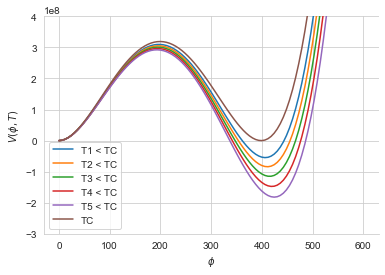

In [148]:
# T = 0 masses
mW0 = 500   #W boson mass
mZ0 = 91  #Z boson mass
mh0 = 125   #Higgs mass 
v0 = 246    #Higgs VEVss
mt0 = 173   #Top quark mass
l = mh0**2/(2*v0**2)  # lambda

# Coefficients in eq (213)
D = (2*mW0**2 + mZ0**2 + 2*mt0**2)/(8*v0**2)
E = (2*mW0**3 + mZ0**3)/(4*np.pi*v0**3)
B = 3/(64*np.pi**2*v0**4)*(2*mW0**4 + mZ0**4 - 4*mt0**4)
Tmin2 = (mh0**2 -8*B*v0**2)/(4*D)

lTemp = lambda T: l - 3*(2*mW0**4*(np.log(mW0**2/T**2) - (5.4076- 1.5))\
                    + mZ0**4*(np.log(mZ0**2/T**2) - (5.4076 -1.5)) - 4*mt0**4*(np.log(mt0**2/T**2) - (2.6351 -1.5)))/(16*np.pi**2*v0**4)

# The critical temperature according to eq (228)
critTemp = lambda TC: TC**2 - lTemp(TC)*D*Tmin2/(lTemp(TC)*D - E**2) 
# Find root of the equation
tempCrit = fsolve(critTemp, mh0)
print('Critical temperature from (228): ', np.around(tempCrit[0], 3))

# Change in lambda
print('lambda(T):', np.around(lTemp(tempCrit)[0], 3))
print('lambda:', np.around(l, 3))

phi = np.linspace(0, 600, 100)
temp = np.linspace(105,115, 100)

def potential(phi, T):
    # Potential given by (213)
    return D*(T**2 - Tmin2)*phi**2 - E*T*np.abs(phi)**3 + lTemp(T)*phi**4/4

def dVdphi(phi, T):
    # Derivative of the potential w.r.t phi
    der = 2*D*(T**2 - Tmin2)*phi - 3*E*T*phi**2 + 4*lTemp(T)*phi**3/4
    #print("dVdphi: ", der)
    return der

def dVdT(phi, T):
    # Derivative of the potential w.r.t T
    return 2*D*T*phi**2 - E*phi**3

def equations(x):
    # The critical temperature is when we have a degenerate minimum, i.e dVdphi = 0 and V = V(phi_F) = 0.
    # Hence define a system of non-linear equations with V = 0 and dV/dphi = 0 
    phi, T = x
    V = potential(phi, T)
    dV = dVdphi(phi, T)
    return [V, dV]

# Use fsolve to find the roots of the system of equations
# Use the last point of the span of phi as an initial guess to find the right minimum, not phi_F = 0
phiAtMin, TC = fsolve(equations, [phi[-1], mh0])
print('The critical temperature, TC: ', np.around(TC, 3))
print('Value of phi at TC: ', np.around(phiAtMin, 3))

potentialTC = potential(phi, TC)
potentialTless = potential(phi, TC - 1)
potentialTless2 = potential(phi, TC - 2)
potentialTless3 = potential(phi, TC - 3)
potentialTless4 = potential(phi, TC - 4)
potentialTless5 = potential(phi, TC - 5)
potentialTless6 = potential(phi, TC - 6)
potentialTmore = potential(phi, TC + 5)
potentialThigh = potential(phi, 200)


plt.figure()
#plt.plot(phi, potentialHiggs, label='T=0-ish')
#plt.plot(phi, potentialTless, label='T < TC')
plt.plot(phi, potentialTless2, label='T1 < TC')
plt.plot(phi, potentialTless3, label='T2 < TC')
plt.plot(phi, potentialTless4, label='T3 < TC')
plt.plot(phi, potentialTless5, label='T4 < TC')
plt.plot(phi, potentialTless6, label='T5 < TC')
plt.plot(phi, potentialTC, label='TC')
# plt.plot(phi, potentialTmore, label='T > TC')
# plt.plot(phi, potentialThigh, label='T >>')
plt.legend()
plt.xlabel('$\phi$')
plt.ylabel('$V(\phi, T)$')
plt.ylim([-3e8, 4e8])
sns.despine()

In [156]:
def equations(r, y, temp):
    """
    Function setting our equation system from the EOM of the bounce. 
    Turning equation of 2nd order ODE, to system of two 1st order ODEs.

        From: dphi^2/dr^2 + (alpha/r)*dphi/dr = dV/dphi

            introduce v = dphi/dr, s.t dv/dr = dphi^2/dr^2
            and then y = [phi, v], dy/dr = [dphi/dr, dv/dr]

        To: dy/dr = [dphi/dr, dv/dr] = [v, -(alpha/r)*dphi/dr + dV/dphi]                                              

    @param r: For T=0, r = sqrt(t^2 + x^2), for finite T r = r
           y: Array of phi and dphi/dr
           alpha: D-1 term, equals either 3 in 4D or 2 in 3D
    @return dydr: Array of dphi/dr and dphi^2/dr^2
    """
    # Pick out the values from y = [phi, v]
    phi = y[0]
    v = y[1]        # v = dphi/dr

    #print("Phi: ", phi, "Temperature: ", temp)    
    # Finite-T
    alpha = 2

    # Define the derivatives
    dphidr = v
    dvdr = - (alpha/r)*v + dVdphi(phi, temp)     # - (alpha/r)*v is the friction term, dVdphi(phi) the derivative of the potential (-)V(phi)
    #print("r: ", r, "dvdr", dvdr, "\n")
    
    # Set dy/dr = [dphi/dr, dv/dr]
    dydr = np.array([dphidr, dvdr])
    
    return dydr

In [153]:
def shooting(r, phiTrueVacuum, phiFalseVacuum, undershoot, tol, temp):
    """
    Shooting method to find the bounce solution.

    EOM for the bounce:
    
        dphi^2/dr^2 = - (alpha/r)*dphi/dr + dV/dphi
    
    Like a point particle moving in a potential -V(phi) subject to a friction term.
    r acts as a time coordinate, and phi the spatial coordinate.

    There are two BCs for the bounce:
        1.) dphi/dr = 0 at r = 0 (no singularities in the origin, starting from rest)
        2.) phi(r) = phi_F at r = infinity  (the particle come at rest in the false vacuum phi_F when r=inf)

    We can turn this BVP to an IVP, we want to find the initial placement of the particle near the true vacuum phi_T that fulfills the BCs.
    We get the ICs:
        1.) dphi/dr = 0 at r = 0
        2.) phi(r) = phi_B at r = 0
    
    Where phi_B is the solution that fulfills BC 2.). 
    Setting dphi/dr = 0 and then an initial placement somewhere close to phi_T we get three different cases:
        a) The particle come at rest at phi_F when r = inf  (right solution, phi_B)
        b) The particle roll past phi_F (overshooting)
        c) The particle does not reach phi_F and experiences damped oscillations around the minimum (undershooting)

    When we have overshooting the initial placement of the particle is too close to phi_T and for undershooting
    it is too far from phi_T and needs to be closer. By trial and error, i.e iterate between over- and undershooting and 
    correct the intial placement until we find the right solution, case a), i.e the bounce solution phi_B.

    @param r: the "time" coordinate
           phiTrueVacuum: The value of phi at the true vacuum
           phiFalseVacuum: The value of phi at the false vacuum
           undershoot: sets the initial placement of the particle s.t we get an undershoot by phiTrueVacuum + undershoot.
           tol: Set tolerance for which we accept our numerical solution
    @return y_num: The numerical solution of the bounce

    """
    
    # Set tolerance for which we accept our numerical solution
    # and a maximum of iteration to abrupt the while loop 
    #tol = 1e-3
    max_iters = 70
    radius = 0

    # If the inparameter 'undershoot' is None we estimate the parameter
    # Does not work atm. 
    # if undershoot is None:
    #     undershoot = (phiFalseVacuum - phiTrueVacuum)/4

    # When phi_T is placed to the right of phi_F
    if phiTrueVacuum > phiFalseVacuum:
        # Set a lower and higher bound for our initial placement of the particle. 
        # Should be choosen s.t high gives an overshoot and low an undershoot.
        high = phiTrueVacuum
        low = phiTrueVacuum - undershoot

    # When phi_T is placed to the left of phi_F
    elif phiTrueVacuum < phiFalseVacuum:
        # Set a lower and higher bound for our initial placement of the particle. 
        # Should be choosen s.t high gives an undershoot and low an overrshoot.
        high = phiTrueVacuum + undershoot
        low = phiTrueVacuum

    print('phi_T = ', phiTrueVacuum, 'phi_F = ', phiFalseVacuum)
    
    # BC 1.), dphi/dr = 0 at r = 0
    dphidr0 = 0

    # Count of iterations
    count = 0

    # Parameter needed for solve_ivp, the first and last value of r
    xspan = (r[0], r[-1])

    while count <= max_iters:
        count = count + 1

        # Set the intial guess of the placement, phi0, as the mean between over- and undershoot              
        phi0 = np.mean([low, high])

        # Collect the two initial conditions
        f0 = [phi0, dphidr0]

        # Solve our system of ODEs given as an IVP, evaluated at every point in r 
        sol = solve_ivp(equations, xspan, f0, method='LSODA', args = (temp,), t_eval = r)
        print(sol.message)      

        # The numerical solution from the solver
        y_num = sol.y[0, :]

        # Felsök
        print('low =', low, ', high = ', high, ', Initial guess: ', phi0)
        print('count: ', count, ', Value of last point in numerical: ', y_num[-1], ', False vacuum: ', phiFalseVacuum)

        # If the initial placement was right, i.e phi0 = phi_B we have found our solution and break
        # the while loop. check if value of the last point in our numerical solution is within tolerance to phi_F.
        if np.abs(y_num[-1] - phiFalseVacuum) <= tol:
            # Find the radius by finding the first value of r when phiB equals 0       
            index = 0
            for i in y_num:
                if np.abs(i - phiFalseVacuum) <= 1:
                    index += 1
                    break
                else:
                    index += 1

            radius = r[index]         
            break
        
        # If the solution is not at the false vacuum we have either an over- or undershoot and 
        # we need to adjust our bounds. Depending on if phi_F is either to the righ or the left 
        # of phi_T the conditions for over- and undershoot will look different.

        # When phi_T is placed to the right of phi_F
        if phiTrueVacuum > phiFalseVacuum:
            # We get an overshoot if the last point of y_num is smaller than phi_F or if
            # it goes to +/- inf, we get the message 'Required step size is less than spacing between numbers.'
            # from solv_ivp if it has very high or low values since it stops working
            if sol.message == 'Required step size is less than spacing between numbers.'\
                or y_num[-1] < phiFalseVacuum or y_num[-1] > phiTrueVacuum or np.isnan(y_num[-1]):
                high = phi0
                print('Overshoot \n')

            # elif sol.message == 'Required step size is less than spacing between numbers.':
            #     high = high -0.1
            #     print('Kaos \n')

            # In all the other cases we have an undershoot                  
            # elif y_num[-1] > phiFalseVacuum or y_num[-1] < phiTrueVacuum:                           
            #     low = phi0
            #     print('Undershoot \n')

            else:
                low = phi0
                print('Undershoot \n')

            # else:
            #     high = phi0
            #     print('Overshoot \n')  

        # When phi_T is placed to the left of phi_F
        elif phiTrueVacuum < phiFalseVacuum:
            # We get an overshoot if the last point of y_num is bigger than phi_F or if
            # it goes to +/- inf, we get the message 'Required step size is less than spacing between numbers.'
            # from solv_ivp if it has very high or low values since it stops working
            if sol.message == 'Required step size is less than spacing between numbers.'\
                or y_num[-1] < phiTrueVacuum or y_num[-1] > phiFalseVacuum:
                low = phi0
                print('Overshoot \n')

            # In all the other cases we have an undershoot
            # Fix condition                  
            else:                           
                high = phi0
                print('Undershoot \n')

        # Get dphi_B/dr needed for the Euclidean action
        dPhiB = sol.y[1, :]

        if radius == 0:
            radius = r[-1]

    return y_num, dPhiB, radius

In [164]:
def shootingAction(r, phiTrueVacuum, phiFalseVacuum, undershoot, tol, temp):
    """
    Shooting method to find the bounce solution.

    EOM for the bounce:
    
        dphi^2/dr^2 = - (alpha/r)*dphi/dr + dV/dphi
    
    Like a point particle moving in a potential -V(phi) subject to a friction term.
    r acts as a time coordinate, and phi the spatial coordinate.

    There are two BCs for the bounce:
        1.) dphi/dr = 0 at r = 0 (no singularities in the origin, starting from rest)
        2.) phi(r) = phi_F at r = infinity  (the particle come at rest in the false vacuum phi_F when r=inf)

    We can turn this BVP to an IVP, we want to find the initial placement of the particle near the true vacuum phi_T that fulfills the BCs.
    We get the ICs:
        1.) dphi/dr = 0 at r = 0
        2.) phi(r) = phi_B at r = 0
    
    Where phi_B is the solution that fulfills BC 2.). 
    Setting dphi/dr = 0 and then an initial placement somewhere close to phi_T we get three different cases:
        a) The particle come at rest at phi_F when r = inf  (right solution, phi_B)
        b) The particle roll past phi_F (overshooting)
        c) The particle does not reach phi_F and experiences damped oscillations around the minimum (undershooting)

    When we have overshooting the initial placement of the particle is too close to phi_T and for undershooting
    it is too far from phi_T and needs to be closer. By trial and error, i.e iterate between over- and undershooting and 
    correct the intial placement until we find the right solution, case a), i.e the bounce solution phi_B.

    @param r: the "time" coordinate
           phiTrueVacuum: The value of phi at the true vacuum
           phiFalseVacuum: The value of phi at the false vacuum
           undershoot: sets the initial placement of the particle s.t we get an undershoot by phiTrueVacuum + undershoot.
           tol: Set tolerance for which we accept our numerical solution
    @return y_num: The numerical solution of the bounce

    """
    
    # Set tolerance for which we accept our numerical solution
    # and a maximum of iteration to abrupt the while loop 
    #tol = 1e-3
    max_iters = 100
    radius = 0


    # Set a lower and higher bound for our initial placement of the particle. 
    # Should be choosen s.t high gives an overshoot and low an undershoot.
    high = phiTrueVacuum
    low = phiTrueVacuum - undershoot
    
    # BC 1.), dphi/dr = 0 at r = 0
    dphidr0 = 0

    # Count of iterations
    count = 0

    # Parameter needed for solve_ivp, the first and last value of r
    xspan = (r[0], r[-1])


    while count <= max_iters:
        count = count + 1

        # Set the intial guess of the placement, phi0, as the mean between over- and undershoot              
        phi0 = np.mean([low, high])

        # Collect the two initial conditions
        f0 = [phi0, dphidr0]

        # Solve our system of ODEs given as an IVP, evaluated at every point in r 
        sol = solve_ivp(equations, xspan, f0, method='LSODA', args = (temp,), dense_output = True)
        z = sol.sol(r)

        # The numerical solution from the solver
        y_num = z[0, :]

        # If the initial placement was right, i.e phi0 = phi_B we have found our solution and break
        # the while loop. check if value of the last point in our numerical solution is within tolerance to phi_F.
        if np.abs(y_num[-1] - phiFalseVacuum) <= tol:
            # Find the radius by finding the first value of r when phiB equals 0       
            index = 0
            for i in y_num:
                if np.abs(i - phiFalseVacuum) <= 1:
                    index += 1
                    break
                else:
                    index += 1

            radius = r[index]         
            break
        
        # If the solution is not at the false vacuum we have either an over- or undershoot and 
        # we need to adjust our bounds. Depending on if phi_F is either to the righ or the left 
        # of phi_T the conditions for over- and undershoot will look different.

        # When phi_T is placed to the right of phi_F
        if phiTrueVacuum > phiFalseVacuum:
            # We get an overshoot if the last point of y_num is smaller than phi_F or if
            # it goes to +/- inf, we get the message 'Required step size is less than spacing between numbers.'
            # from solv_ivp if it has very high or low values since it stops working
            if sol.message == 'Required step size is less than spacing between numbers.'\
                or y_num[-1] < phiFalseVacuum or y_num[-1] > phiTrueVacuum or np.isnan(y_num[-1]):
                high = phi0
                #print('Overshoot \n')

            else:
                low = phi0
                #print('Undershoot \n')

        if radius == 0:
            radius = r[-1]
        
        R = np.linspace(r[0], radius, 100)
        bounce = sol.sol(R)

        # Get phi_B and dphi_B/dr needed for the Euclidean action
        dPhiB = bounce[1,:]
        phiB = bounce[0,:]

    return y_num, dPhiB, phiB, radius, R

Action:  317.94957492752343


(-1.0, 600.0)

<Figure size 432x288 with 0 Axes>

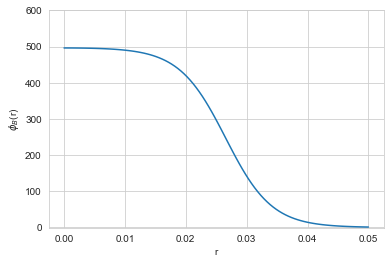

In [166]:
# Bounce works
#phi = np.linspace(-100, 300, 100)
T = TC-18

phiMin = fsolve(dVdphi, phi[-1], args = (T,))

r = np.linspace(0.00001, 0.05, 100)
phiB_numLong, dPhiB_num, phiB, radius, R = shootingAction(r, phiMin[0], 0, undershoot = 6, tol = 1e-1, temp = T)

potentialBounce = potential(phiB, T)
integrand = R**2*(0.5*dPhiB_num**2 + potentialBounce)
integral = np.trapz(integrand, R)
S = integral*4*np.pi
print("Action: ", S/T)

plt.figure()
plt.plot(r, phiB_numLong, label='T1')
plt.xlabel('r')
plt.ylabel('$\phi_B$(r)')
plt.ylim([-1, 600])

Action:  842.7515816349112 Temperature:  110.17132818904439
Action:  707.31950961812 Temperature:  109.17132818904439
Action:  613.5592950419601 Temperature:  108.17132818904439
Action:  535.4062801339743 Temperature:  107.17132818904439
Action:  474.2476428512683 Temperature:  106.17132818904439
Action:  425.06915875523697 Temperature:  105.17132818904439
Action:  382.75854098864625 Temperature:  104.17132818904439
Action:  347.7760730783107 Temperature:  103.17132818904439
Action:  317.94957492752343 Temperature:  102.17132818904439
Action:  294.2060831555255 Temperature:  101.17132818904439
Action:  271.5325669324974 Temperature:  100.17132818904439
Action:  256.03977406112506 Temperature:  99.17132818904439
Action:  248.14935923685832 Temperature:  98.17132818904439
Action:  242.2487846604327 Temperature:  97.17132818904439
Action:  236.52711193114166 Temperature:  96.17132818904439
Action:  228.66678237313434 Temperature:  95.17132818904439
Action:  215.33630166115213 Temperature:

Text(0, 0.5, 'S/T')

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

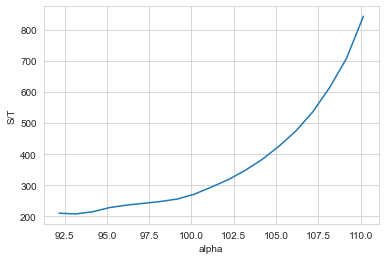

In [234]:
temperatures = np.arange(TC-10, TC-29, -1)  #TC-10
action = []

#plt.figure()

for t in temperatures:

    if t >= (TC-11):
        r = np.linspace(0.00001, 0.07, 100)

    elif t <= (TC-12) and t > TC-15:
        r = np.linspace(0.00001, 0.06, 100)

    elif t <= (TC-15) and t > TC-21:
        r = np.linspace(0.00001, 0.05, 100)

    elif t <= (TC-21) and t > TC-22:
        r = np.linspace(0.00001, 0.038, 100)

    elif t <= (TC-22) and t > TC-23:
        r = np.linspace(0.00001, 0.036, 100)

    elif t <= (TC-23) and t > TC-24:
        r = np.linspace(0.00001, 0.035, 100)

    elif t <= (TC-24) and t > TC-25:
        r = np.linspace(0.00001, 0.034, 100)

    elif t <= (TC-25) and t > TC-26:
        r = np.linspace(0.00001, 0.033, 100)

    elif t <= (TC-26) and t > TC-27:
        r = np.linspace(0.00001, 0.0319, 100)

    elif t <= (TC-27) and t > TC-28:
        r = np.linspace(0.00001, 0.0312, 100)

    else:
        r = np.linspace(0.00001, 0.0308, 100)


    phiMin = fsolve(dVdphi, phi[-1], args = (t,))
    phiB_numLong, dPhiB_num, phiB, radius, R = shootingAction(r, phiMin[0], 0, undershoot = 6, tol = 1e-1, temp = t)
    # plt.plot(r, phiB_numLong, label=(np.around(t, 0)))
    # plt.xlabel('r')
    # plt.ylabel('$\phi_B$(r)')
    # plt.title(t)

    potentialBounce = potential(phiB, t)
    integrand = R**2*(0.5*dPhiB_num**2 + potentialBounce)
    integral = np.trapz(integrand, R)
    S = integral*4*np.pi
    print("Action: ", S/t, "Temperature: ", t)
    action.append(S/t)

#plt.legend()

action = np.array(action)

plt.figure()
plt.plot(temperatures, action, label='Numerical action')
plt.xlabel('alpha')
plt.ylabel('S/T')

